In [17]:
from poisson_equation.trainer import DGMTrainerPE, DGMTrainerPE_2D
from poisson_equation.utility_functions import *
from poisson_equation.data_sampling import *
import poisson_equation_network as network
from poisson_equation.visualize import *

# Deep Galerkin Method with Poisson Equation in 1D (Time Independent)

In [18]:
lx_1d = 2.0
bounds_1d = [[0.0, lx_1d]]

# PDE Constants (For Poisson Equation )

# Data Sizes
N_INT = 1500
N_BC =400


## Data Preparation

In [19]:
# 1. Domain Data (x in [0, lx_1d])
x_int = generate_domain_points(N_INT, bounds_1d)
#print("Internal domain points ",x_int)
f_x = source_term_fn_1D(x_int).to(device)
domain_data = (x_int, f_x)

# 2 Boundary Points
c_bc = generate_bc_points(N_BC, bounds_1d)
u_bc = boundary_condition_fn_1D(c_bc).to(device)
bc_data = (c_bc, u_bc)

## Visualization of the generated Data Points

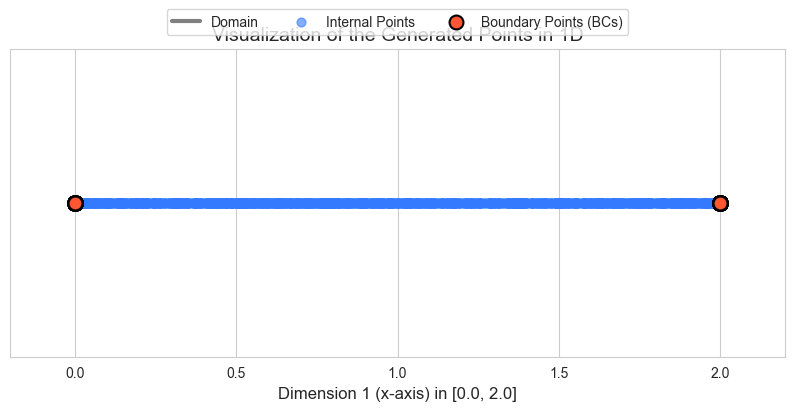

In [20]:
visualize_points_1d(x_int,c_bc, bounds_1d)

## Network Initialization

In [21]:
num_layers = 5
nodes_per_layer = 64
learning_rate = 0.001
epochs = 1000

model = network.DGMNet(nodes_per_layer, num_layers, 1).to(device)
trainer = DGMTrainerPE(
    model=model,
    learning_rate=learning_rate
)

## Training

In [22]:
trainer.train(
    epochs=epochs,
    domain_data=domain_data,
    bc_data=bc_data,
    lambda_pde=50.0,
    lambda_bc=50.0
)

Starting training on mps. Interior: 1500, BC: 400 points.
Epoch 100/1000 | Total Loss: 10.6544 | L_pde: 0.1180 | L_bc: 0.0951
Epoch 200/1000 | Total Loss: 0.3436 | L_pde: 0.0067 | L_bc: 0.0002
Epoch 300/1000 | Total Loss: 0.0592 | L_pde: 0.0012 | L_bc: 0.0000
Epoch 400/1000 | Total Loss: 0.0268 | L_pde: 0.0005 | L_bc: 0.0000
Epoch 500/1000 | Total Loss: 0.0202 | L_pde: 0.0004 | L_bc: 0.0000
Epoch 600/1000 | Total Loss: 0.0108 | L_pde: 0.0002 | L_bc: 0.0000
Epoch 700/1000 | Total Loss: 0.0084 | L_pde: 0.0002 | L_bc: 0.0000
Epoch 800/1000 | Total Loss: 0.0077 | L_pde: 0.0002 | L_bc: 0.0000
Epoch 900/1000 | Total Loss: 0.0055 | L_pde: 0.0001 | L_bc: 0.0000
Epoch 1000/1000 | Total Loss: 0.0044 | L_pde: 0.0001 | L_bc: 0.0000


## Visualization of the Solutionn

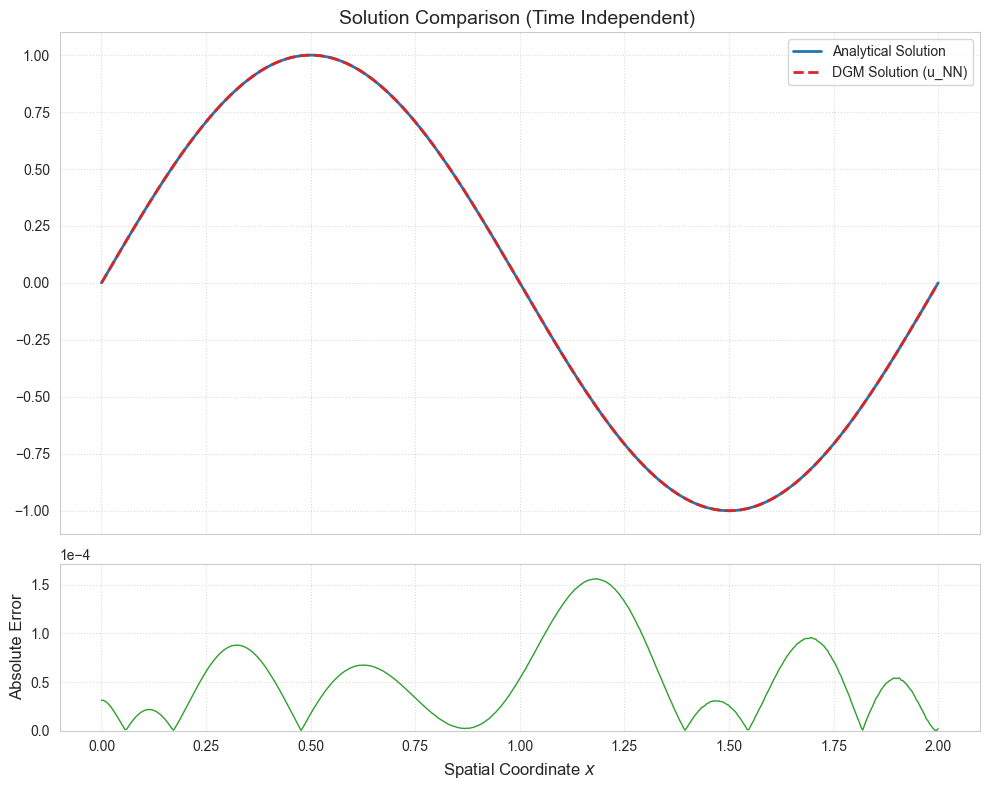

In [23]:
visualize_solution_1d(model, lx_1d,n_test_points=500)


# Deep Galerkin Method with Poisson Equation in 2D

In [33]:
lx_2d = 2.0
ly_2d = 2.0
T_max = 2.0
bounds_2d = [[0.0, lx_2d],[0.0, ly_2d]]

# PDE Constants (for Heat Equation: u_t = alpha * u_xx + f)
ALPHA = 0.01

# Data Sizes
N_INT = 1500
N_BC =500

## Data Preparation

In [34]:
# 1. Interior Data (t in [0, T_max], x in [0, lx_1d])
spatial_coords = generate_domain_points(N_INT, bounds_2d)
x_int = spatial_coords[:, 0:1]
y_int = spatial_coords[:, 1:2]
f_xy = source_term_fn_2d(x_int, y_int).to(device)
interior_data = (x_int, y_int,  f_xy)


# 2. Boundary Condition Data (t in [0, T_max], x = 0 or 1)
spatial_coords_bc = generate_bc_points(N_BC, bounds_2d)
x_bc = spatial_coords_bc[:, 0:1]
y_bc = spatial_coords_bc[:, 1:2]
u_bc = boundary_condition_fn_2d(x_bc, y_bc).to(device)
bc_data = (x_bc,y_bc, u_bc)


## Visualization of the Generated Data Points

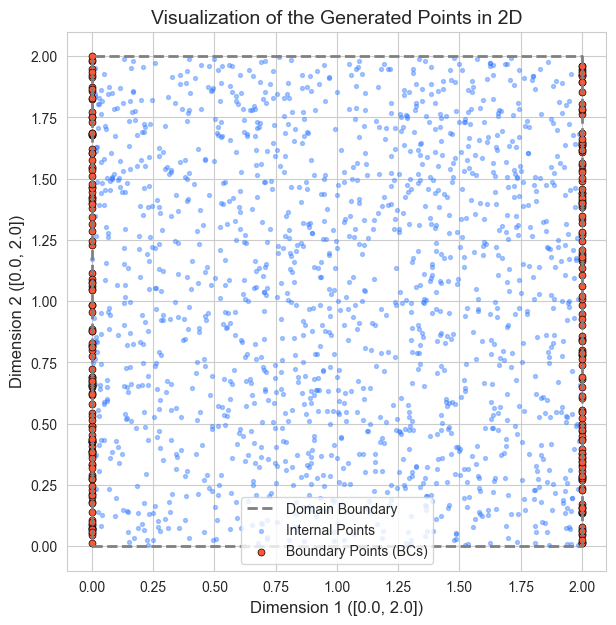

In [35]:
visualize_points_2d(spatial_coords, spatial_coords_bc, bounds_2d)

## Network Initialization

In [40]:
num_layers = 6
nodes_per_layer = 128
learning_rate = 0.001
epochs = 5000

model = network.DGMNet(nodes_per_layer, num_layers, 2).to(device)

trainer = DGMTrainerPE_2D(
    model=model,
    learning_rate=learning_rate
)

## Training

In [ ]:
trainer.train(
    epochs=epochs,
    domain_data=interior_data,
    bc_data=bc_data,
    lambda_pde=5.0,
    lambda_bc=5.0
)

Epoch 100/5000 | Total Loss: 4.4795 | L_pde: 0.8236 | L_bc: 0.0723


## Visualization of the Solution

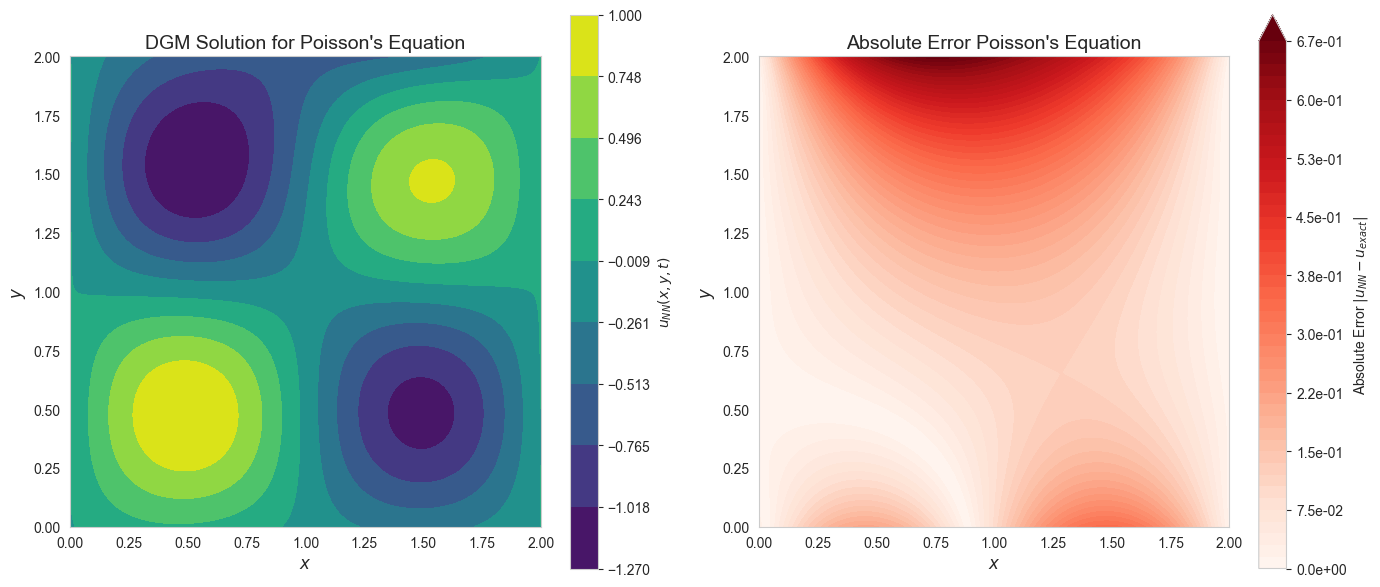

In [38]:
visualize_2d(
    model=model,
    bounds=bounds_2d,
    n_grid=500
)

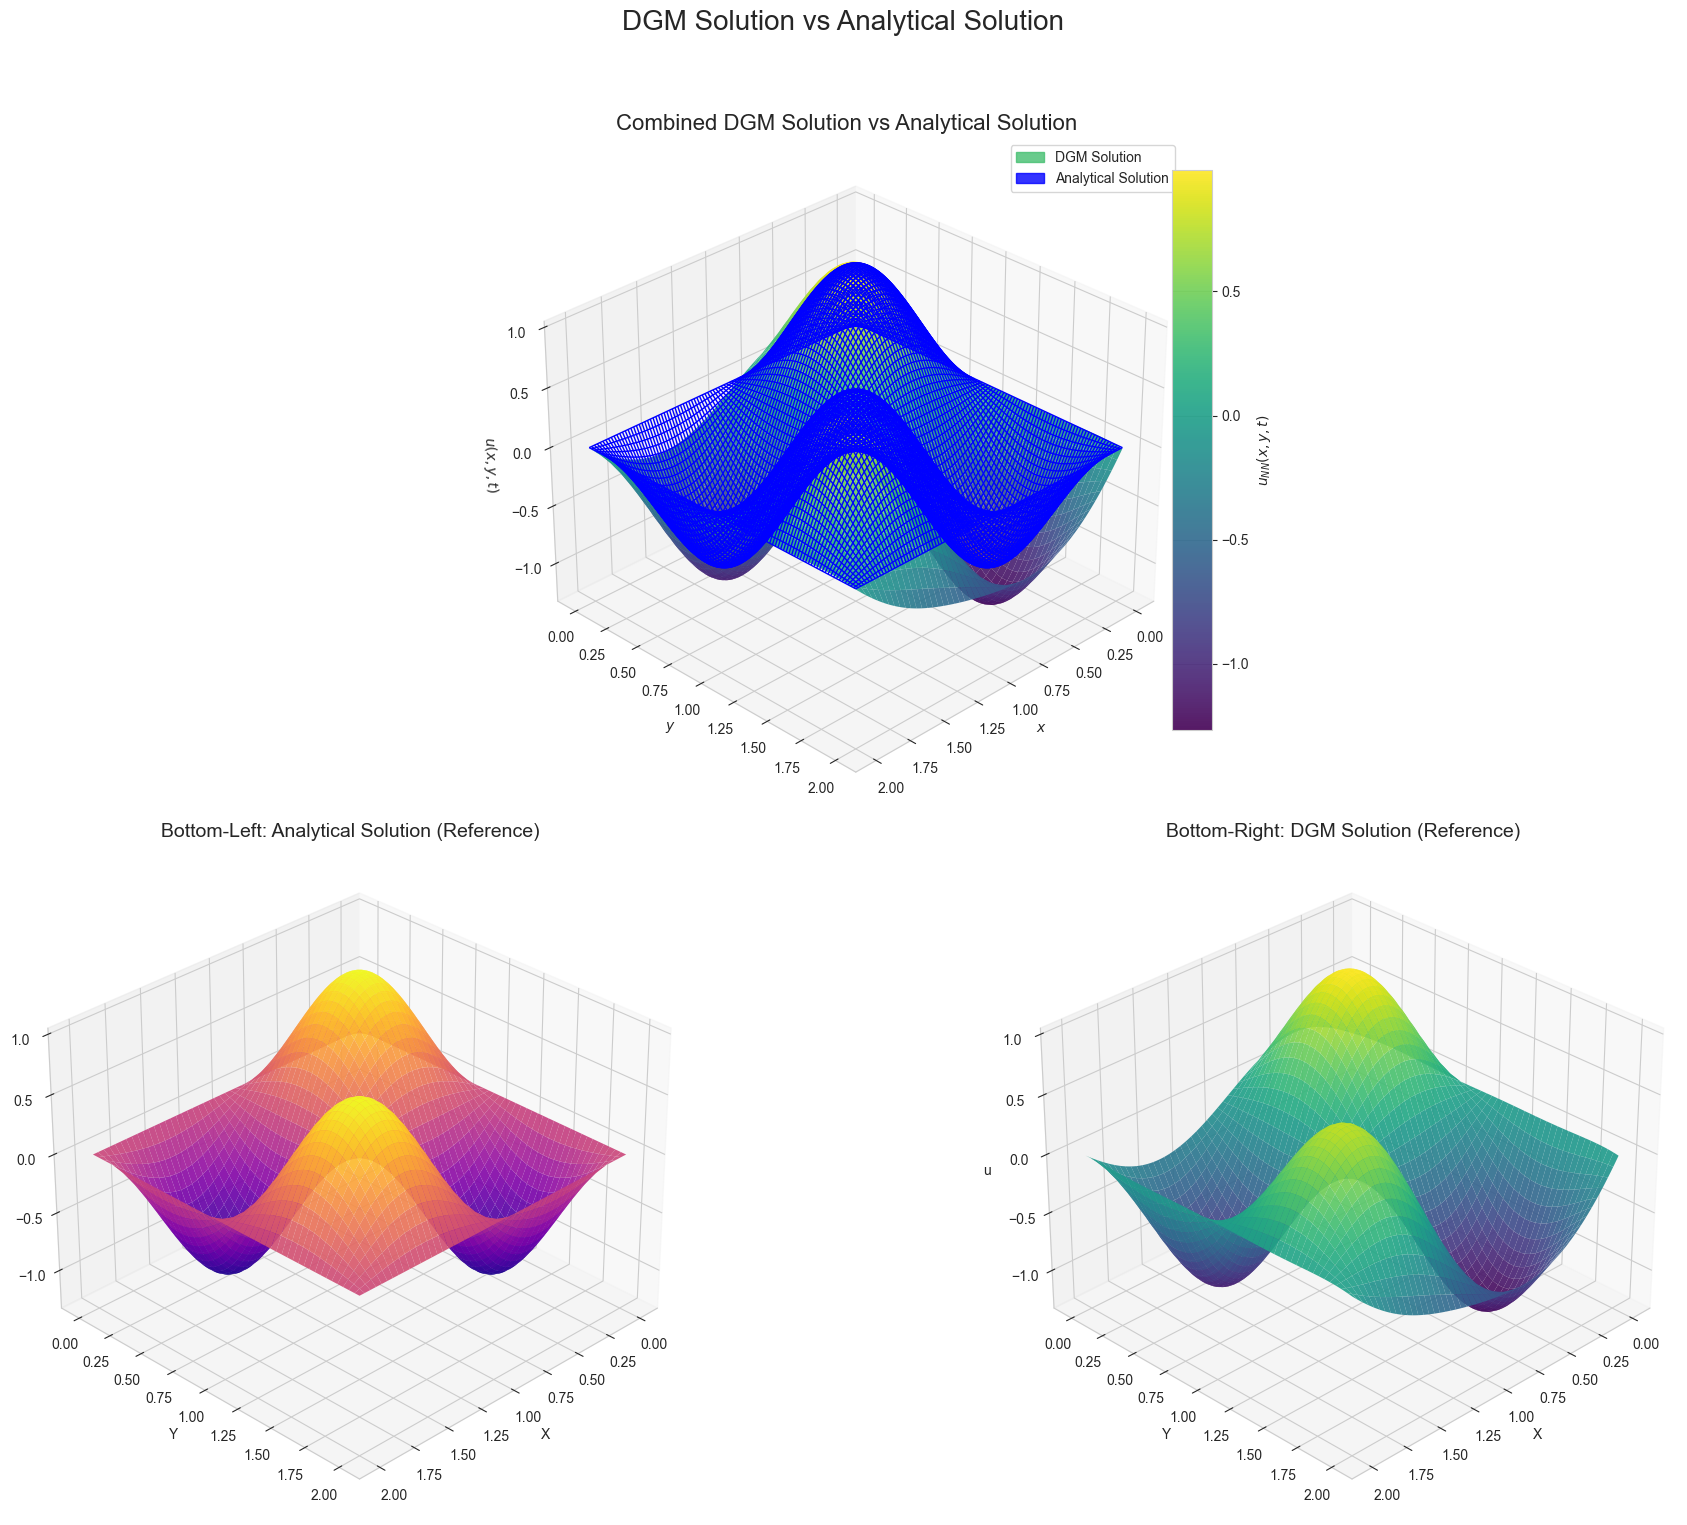

In [39]:
visualize_solution_2d(
    model=model,
    bounds=bounds_2d,
    n_grid=500
)